# Train segmentation model

## Import libs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
# sys.path.insert(0,"..")
# os.chdir('..')

In [ ]:
# This cell for Google Colab
# Upload the dataset to Google drive to use this notebook in Google Colab
# Uncomment following code for connecting to Google Drive to get access to dataset
# import os,sys,inspect
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/to dataset folder')
# %cd /content/drive/to dataset folder
# if os.path.exists("datasets"):
#   print("Dataset already exists!")
# else:
#   # Extract files
#   print("Unzipping dataset...")
#   !unzip "datasets.zip"

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch

from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset

# Reproducibility
random.seed(0)
os.environ['PYTHONHASHSEED'] = str(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Experiments are stored using the loss function names
EXPERIMENT_NAME = "unet_isic2018_BCE+Dice"

ROOT_DIR = os.path.abspath(".")
LOG_PATH = os.path.join(ROOT_DIR, "logs", EXPERIMENT_NAME)

if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
    os.mkdir(os.path.join(ROOT_DIR, "logs"))
    
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)

cuda:0


## Load data

Download ISIC-2018 lesion segmentation dataset from https://challenge.isic-archive.com/data/

In [4]:
class ISIC2018_dataloader(Dataset):
    def __init__(self, data_folder, is_train=True):
        self.is_train = is_train
        self._data_folder = data_folder
        self.build_dataset()

    def build_dataset(self):
        self._input_folder = os.path.join(self._data_folder, 'ISIC2018_Task1-2_Training_Input')
        self._label_folder = os.path.join(self._data_folder, 'ISIC2018_Task1_Training_GroundTruth')
        self._images = sorted(glob.glob(self._input_folder + "/*.jpg"))
        self._labels = sorted(glob.glob(self._label_folder + "/*.png"))
        
        self.train_images, self.test_images, self.train_labels, self.test_labels = train_test_split(self._images, self._labels, 
                                                                            test_size=0.2, shuffle=False, random_state=0)
        
    def __len__(self):
        if self.is_train:
            return len(self.train_images)
        else:
            return len(self.test_images)

    def __getitem__(self, idx):
        
        if self.is_train:
            img_path = self.train_images[idx]
            mask_path = self.train_labels[idx]
        else:
            img_path = self.test_images[idx]
            mask_path = self.test_labels[idx]
            
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('P')
        
        transforms_image = transforms.Compose([transforms.Resize((256, 256)), transforms.CenterCrop((256,256)),
                                             transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])
        
        transforms_mask = transforms.Compose([transforms.Resize((256, 256)), transforms.CenterCrop((256,256)),
                                             transforms.ToTensor()])
        
        image = transforms_image(image)
        mask = transforms_mask(mask)
        
        sample = {'image': image, 'mask': mask}
        return sample
    
    

train_dataset = ISIC2018_dataloader("datasets")
test_dataset = ISIC2018_dataloader("datasets", is_train=False)

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [5]:
dt = next(iter(train_dataloader))
x = dt["image"]
y = dt["mask"]
x.shape, y.shape

(torch.Size([5, 3, 256, 256]), torch.Size([5, 1, 256, 256]))

(256, 256, 3)


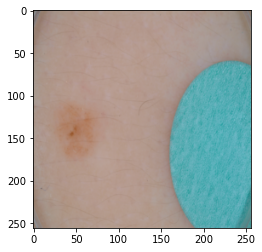

In [6]:
def to_img(ten):
    ten =(ten[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    ten=(ten*255).astype(np.uint8)
    return ten

a = to_img(x)
print(a.shape)
plt.imshow(a)
#plt.imshow(a, cmap='gray')

(256, 256, 1)


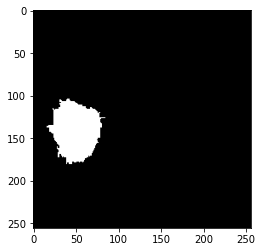

In [7]:
a = to_img(y)
# a = a[:,:,0]
print(a.shape)
plt.imshow(a, cmap='gray')

## Load model

In [8]:
import torchvision

###### UNet model
#########################################################################################
""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
        # NOTE: 
        # nn.Conv2d(64, 1, kernel_size=1, padding=0) is mathematically same as 
        # nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)
        return outputs
######################################################################################### 


# Define model
model = build_unet()

# Send to GPU
model = model.to(DEVICE)

In [9]:
# All parameters
all_params = sum(p.numel() for p in model.parameters())
print("All parameters ", all_params)

# Trainable parameters
all_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters ", all_train_params)

All parameters  31043521
Trainable parameters  31043521


## Setup optim and loss

In [10]:
# Define Loss Function:
# Uncomment the loss function to use and then call the loss function class in the criterion in the next cell
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
# ALPHA1 = 0.8
# GAMMA1 = 2

# class FocalLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(FocalLoss, self).__init__()

#     def forward(self, inputs, targets, alpha=ALPHA1, gamma=GAMMA1, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = torch.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         #first compute binary cross-entropy 
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         BCE_EXP = torch.exp(-BCE)
#         focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
#         return focal_loss
# ALPHA2 = 0.5
# BETA2 = 0.5

# class TverskyLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(TverskyLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1, alpha=ALPHA2, beta=BETA2):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = torch.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         #True Positives, False Positives & False Negatives
#         TP = (inputs * targets).sum()    
#         FP = ((1-targets) * inputs).sum()
#         FN = (targets * (1-inputs)).sum()
       
#         Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
#         return 1 - Tversky
# ALPHA3 = 0.5
# BETA3 = 0.5
# GAMMA3 = 1

# class FocalTverskyLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(FocalTverskyLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1, alpha=ALPHA3, beta=BETA3, gamma=GAMMA3):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = torch.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         #True Positives, False Positives & False Negatives
#         TP = (inputs * targets).sum()    
#         FP = ((1-targets) * inputs).sum()
#         FN = (targets * (1-inputs)).sum()
        
#         Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
#         FocalTversky = (1 - Tversky)**gamma
                       
#         return FocalTversky
# class IoULoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(IoULoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = torch.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         #intersection is equivalent to True Positive count
#         #union is the mutually inclusive area of all labels & predictions 
#         intersection = (inputs * targets).sum()
#         total = (inputs + targets).sum()
#         union = total - intersection 
        
#         IoU = (intersection + smooth)/(union + smooth)
                
#         return 1 - IoU

In [11]:
# Call the loss function in criterion
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss() # loss combines a Sigmoid layer and the BCELoss in one single class

# These are for applying the combinations of the loss functions.
# criterion_bce = nn.BCEWithLogitsLoss()
# criterion_dice = DiceLoss()
# criterion_focal=FocalLoss()
# criterion_tversky=TverskyLoss()
# criterion_FT=FocalTverskyLoss()
# criterion_IoU=IoULoss()

## Train and eval functions

In [12]:
def train(model, epoch):
    model.train()
    for batch_idx, data in enumerate(train_dataloader):
        data, target = data["image"].to(DEVICE), data["mask"].to(DEVICE)
        output = model.forward(data.float())
        loss=criterion(output.float(), target.float())
        
#These are for the combinations of the loss functions
#         loss1=criterion_bce(output.float(), target.float())
#         loss2=criterion_dice(output.float(), target.float())
#         loss3=criterion_focal(output.float(), target.float())
#         loss4=criterion_tversky(output.float(), target.float())
#         loss5=criterion_FT(output.float(), target.float())
#         loss6=criterion_IoU(output.float(), target.float())
#         loss=loss1+loss2+...    Keep adding
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # if batch_idx % 10 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_dataloader.dataset),
        #         100. * batch_idx / len(train_dataloader), loss.data))
            
def test(model):
    model.eval()
    
    with torch.no_grad():
        test_loss = 0
        jaccard = 0
        dice = 0

        for data in test_dataloader:
            data, target = data["image"].to(DEVICE), data["mask"].to(DEVICE)
            output = model(data.float())  
            test_loss += criterion(output.float(), target.float()).item()
            
            output = torch.sigmoid(output) # Turn activations into probabilities by feeding through sigmoid
            gt = target.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy()
            pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5

            intersection = pred * gt
            union = pred + gt - intersection
            jaccard += (np.sum(intersection)/np.sum(union))  
            dice += (2. * np.sum(intersection) ) / (np.sum(pred) + np.sum(gt))
    
        test_loss /= len(test_dataloader)
        jaccard /= len(test_dataloader)
        dice /= len(test_dataloader)

        losses.append(test_loss)
        jacs.append(jaccard)
        dices.append(dice)


        print('Average Loss: {:.3f}'.format(test_loss))
        print('Jaccard Index : {:.3f}'.format(jaccard * 100))
        print('Dice Coefficient : {:.3f}'.format(dice * 100))
        print('==========================================')
        print('==========================================')
        return dice

## Train model

In [13]:
losses = []
jacs = []
dices = []

score = 0
best_score = 0

start_time = time.time()

N_EPOCHS = 30 # Do 100 or more!
 
for epoch in range(1, N_EPOCHS):
    print("Epoch: {}".format(epoch))
    train(model, epoch)
    score = test(model)
    
    # Save best model
    if score > best_score:
        print("Saving model at dice={:.3f}".format(score))
        torch.save(model.state_dict(), '{}/{}.pth'.format(LOG_PATH, EXPERIMENT_NAME))
        best_score = score

        
# Save losses
losses = np.array(losses)
np.savetxt("{}/{}_loss.txt".format(LOG_PATH, EXPERIMENT_NAME), losses, delimiter=",")
jacs = np.array(jacs)
np.savetxt("{}/{}_jacs.txt".format(LOG_PATH, EXPERIMENT_NAME), jacs, delimiter=",")
dices = np.array(dices)
np.savetxt("{}/{}_dices.txt".format(LOG_PATH, EXPERIMENT_NAME), dices, delimiter=",")

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))
print("--- Time taken to train : %s mins ---" % ((end_time - start_time)//60))

Epoch: 1
Average Loss: 0.238
Jaccard Index : 70.975
Dice Coefficient : 80.905
Saving model at dice=0.809
Epoch: 2
Average Loss: 0.229
Jaccard Index : 72.021
Dice Coefficient : 81.688
Saving model at dice=0.817
Epoch: 3
Average Loss: 0.223
Jaccard Index : 72.274
Dice Coefficient : 81.413
Epoch: 4
Average Loss: 0.352
Jaccard Index : 67.057
Dice Coefficient : 77.296
Epoch: 5
Average Loss: 0.232
Jaccard Index : 74.586
Dice Coefficient : 83.528
Saving model at dice=0.835
Epoch: 6
Average Loss: 0.182
Jaccard Index : 77.884
Dice Coefficient : 86.204
Saving model at dice=0.862
Epoch: 7
Average Loss: 0.226
Jaccard Index : 77.092
Dice Coefficient : 85.415
Epoch: 8
Average Loss: 0.215
Jaccard Index : 76.646
Dice Coefficient : 85.164
Epoch: 9
Average Loss: 0.235
Jaccard Index : 76.201
Dice Coefficient : 84.598
Epoch: 10
Average Loss: 0.227
Jaccard Index : 76.420
Dice Coefficient : 84.676
Epoch: 11
Average Loss: 0.183
Jaccard Index : 78.009
Dice Coefficient : 86.306
Saving model at dice=0.863
Epoch

In [14]:
best_score

0.8799850391321179

In [15]:
max(jacs), max(dices), min(losses)

(0.8050537468625056, 0.8799850391321179, 0.18170441238134238)

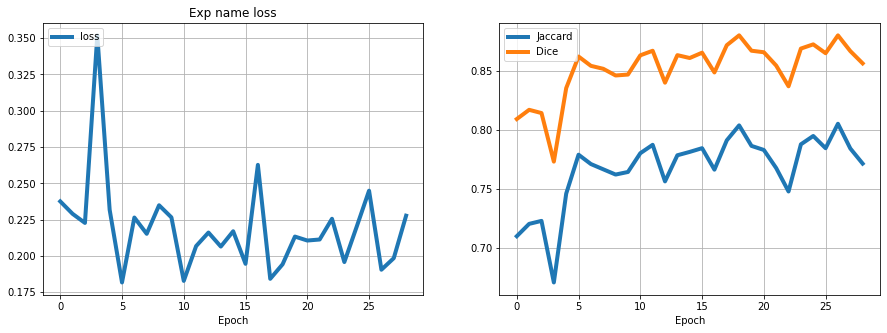

In [16]:
# Plot training & validation loss values
# b, g, r, y, o, -g, -m,
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(losses,linewidth=4)
plt.title('{} loss'.format("Exp name"))
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'], loc='upper left')
plt.grid(True)
# Plot training & validation iou_score values
plt.subplot(122)
plt.plot(jacs,linewidth=4)
plt.plot(dices,linewidth=4)
#plt.title('{} IOU score'.format(experiment_name))
#plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Jaccard', 'Dice'], loc='upper left')
plt.savefig('{}/{}_graph.png'.format(LOG_PATH, EXPERIMENT_NAME), dpi=300)
plt.show()